In [50]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
%load_ext line_profiler

repo_path = '/Users/gkeating/repo/sma_phasing_sims'

def load_swarm_data(filename):
    with open(os.path.join(repo_path, filename)) as json_file:
        swarm_data = json.load(json_file)
    # Grab the total length of the data real quick
    n_data = len(swarm_data)

    # We're gonna be doing a lot of diff operations, which means in some cases we'll want
    # to pad some arrays with zeros. Construct some arrays now for the sake of convenience
    zero_pad = [
        np.zeros((1,len(swarm_data[0]['phases_lsb']))),
        np.zeros((1,len(swarm_data[0]['phases_usb']))),
    ]

    # These are the implemented phase values recorded in SWARM
    phases_lsb = np.array([swarm_data[idx]['phases_lsb'] for idx in range(n_data)])
    phases_usb = np.array([swarm_data[idx]['phases_usb'] for idx in range(n_data)])

    # These are the derived offsets/error terms for each antenna, given the implemented values
    cal_solution_lsb = np.array([swarm_data[idx]['cal_solution_lsb'][2] for idx in range(n_data)])
    cal_solution_usb = np.array([swarm_data[idx]['cal_solution_usb'][2] for idx in range(n_data)])

    # Let's calculate the "true" phase -- that is, assume that the solutions are perfect, and
    # use that to figure out what the antenna phase should _actually_ have been at time of obs.
    # There's kind of a funny padding operation that's needed here because of the order values
    # in the JSON file are recorded (soln's derived -> values implemented -> values recorded).
    true_phase_lsb = np.concatenate((zero_pad[0], phases_lsb[:-1] + cal_solution_lsb[1:]))
    true_phase_usb = np.concatenate((zero_pad[1], phases_usb[:-1] + cal_solution_usb[1:]))

    # Convert times from UNIX -> fractional UTC hours
    time_stamps = (np.array([swarm_data[idx]['int_time'] for idx in range(n_data)]) % 86400) / 3600.0
    
    return (true_phase_lsb, true_phase_usb, time_stamps)

def sim_pid_loop(phase_data, int_length=8, kp=0.75, ki=0.40, kd=0.01):
    n_times = phase_data.shape[0]
    n_inputs = phase_data.shape[1]
    int_window = np.zeros((int_length, n_inputs))
    new_epsilon = np.zeros((n_times, n_inputs))
    last_cal = phase_data[0]

    for idx in range(n_times):
        cal_soln = (((phase_data[idx] - last_cal) + 180.0 ) % 360.0) - 180.0
        new_epsilon[idx] = cal_soln
        #int_window = np.roll(int_window, 1, axis=0)
        #int_window[0] = cal_soln
        pos_mark = np.mod(idx, int_length)
        int_window[pos_mark] = cal_soln

        pid_response = (
            (kp * cal_soln)
            + (int_window.sum(axis=0) * (ki / int_length))
            + ((int_window[pos_mark] - int_window[pos_mark - 1]) * kd)
        )
        last_cal += pid_response
        last_cal = ((last_cal + 180.0 ) % 360.0) - 180.0
    
    return new_epsilon

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [117]:
%%time

n_kp = 11
n_ki = 21
n_kd = 11

results_arr = np.zeros((n_kp,n_ki,n_kd))
int_length = 8
phase_lsb,phase_usb,time_vals = load_swarm_data('phasing_data/vlbi_cal.106-2021.json')
print("Processing", end="")
for idx, kp in enumerate(np.linspace(0, 2, num=n_kp)):
    for jdx, ki in enumerate(np.linspace(-1, 3, num=n_ki)):
        for kdx, kd in enumerate(np.linspace(-1, 1, num=n_kd)):
            for phase_arr in [phase_lsb, phase_usb]:
                del_vals = sim_pid_loop(phase_arr, int_length=int_length, kp=kp, ki=ki, kd=kd)
                ph_eff_vals = np.abs(
                    np.mean(np.exp(-1j*np.deg2rad(del_vals.reshape((del_vals.shape[0], 4, -1)))),axis=2)
                )**2.0
                results_arr[idx,jdx,kdx] += np.sum(ph_eff_vals**2.0)
    print(".", end="")
print("complete!")

Processing...........complete!
CPU times: user 2min 56s, sys: 1.13 s, total: 2min 58s
Wall time: 2min 58s


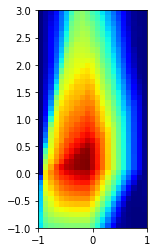

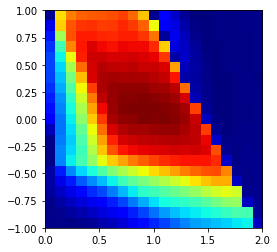

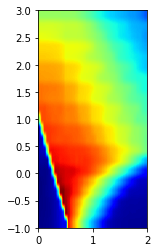

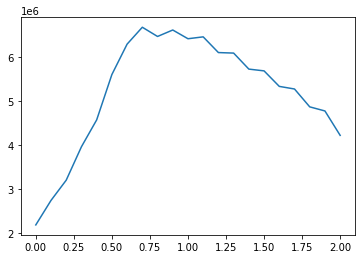

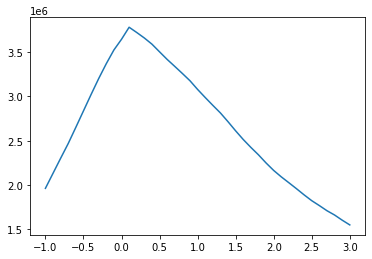

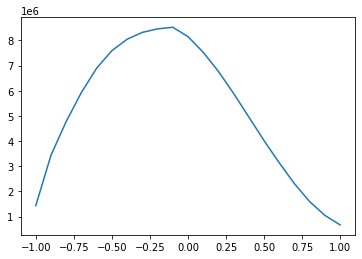

In [116]:
plt.imshow(np.sum(results_arr,axis=0), extent=[-1, 1, -1, 3], origin='lower', cmap='jet')
plt.show()
plt.imshow(np.sum(results_arr,axis=1), extent=[0, 2, -1, 1], origin='lower', cmap='jet')
plt.show()
plt.imshow(np.sum(results_arr,axis=2), extent=[0, 2, -1, 3], origin='lower', cmap='jet')
plt.show()
plt.plot(np.linspace(0, 2, num=n_kp), results_arr.sum(axis=2).sum(axis=1))
plt.show()
plt.plot(np.linspace(-1, 3, num=n_ki), results_arr.sum(axis=2).sum(axis=0))
plt.show()
plt.plot(np.linspace(-1, 1, num=n_kd), results_arr.sum(axis=1).sum(axis=0))
plt.show()